# Import packages

In [54]:
import mne
import numpy as np
import scipy
from scipy.signal import savgol_filter
from scipy.stats import trim_mean
from sklearn.manifold import MDS, TSNE
from sklearn.cluster import KMeans
from sklearn.covariance import shrunk_covariance
import copy

import torch
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
from pylab import mpl
import seaborn as sns
import dill

import warnings
warnings.filterwarnings('ignore')

from utils import UDEC_Network, draw_states, ttest_for_clusters

In [2]:
plt.rcParams['font.family']=['Arial', 'Times New Roman']
plt.style.use('default')
mpl.rcParams["axes.unicode_minus"] = False
%config InlineBackend.figure_format = 'svg'

font = {'family':['Arial', 'Times New Roman'], 'color':'k', 'weight':'normal', 'size':10 }
colors = sns.color_palette('tab10')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

mne.cuda.init_cuda(verbose=True)

cuda:0
Now using CUDA device 0
Enabling CUDA with 10.09 GB available memory


# Load EEG data

In [3]:
subject_num = 40
erp_data = np.zeros((subject_num, 2, 28, 256)) # [subject, type, ch, time]

trim = lambda x: trim_mean(x, 0.3, axis=0)

file_path_pre = './N170_Data/'
file_path_post = '_N170_shifted_ds_reref_ucbip_hpfilt_ica_corr_cbip_elist_bins_epoch_interp_ar.set'

for sub in range(subject_num):
    file_name = file_path_pre + str(sub+1) + file_path_post
    # from -200 ms to 800 ms, baseline correction performed
    epo = mne.io.read_epochs_eeglab(file_name);
    
    # epo.ch_names
    eog_ch_list = ['HEOG_left', 'HEOG_right', 'VEOG_lower', '(corr) HEOG',
                    '(corr) VEOG', '(uncorr) HEOG', '(uncorr) VEOG']
    epo.drop_channels(eog_ch_list);

    reject = dict(eeg=80e-6 )      # unit: V (EEG channels)
    flat_criteria = dict(eeg=1e-6)
    epo.drop_bad(reject, flat=flat_criteria);
    # epo.plot_drop_log();
    # epo.plot(events=True);

    events_dict = { }
    for pic in ['face', 'car']:
        events_dict[pic] = []

    for id in epo.event_id:
        # bin 1 Faces
        # bin 2 Cars
        # bin 3 Scrambled Faces
        # bin 4 Scrambled Cars
        if id[1] == '1':
            events_dict['face'].append(id)
        elif id[1] == '2':
            events_dict['car'].append(id)
        
    for i, pic in enumerate(['face', 'car']):
        erp_data[sub, i] = epo[events_dict[pic]].average(method=trim).get_data()

Extracting parameters from e:\论文写作\论文2数据分析\N170\N170_Data\1_N170_shifted_ds_reref_ucbip_hpfilt_ica_corr_cbip_elist_bins_epoch_interp_ar.set...
Not setting metadata
240 matching events found
No baseline correction applied
0 projection items activated
Ready.
    Rejecting  epoch based on EEG : ['PO4']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['PO4']
    Rejecting  epoch based on EEG : ['PO4']
    Rejecting  epoch based on EEG : ['P7', 'PO8']
    Rejecting  epoch based on EEG : ['PO7', 'PO3', 'PO4']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['FP1', 'PO7', 'PO8']
    Rejecting  epoch based on EEG : ['FP1', 'F7', 'FC4']
    Rejecting  epoch based on EEG : ['FC4']
    Rejecting  epoch based on EEG : ['FP1', 'F7']
    Rejecting  epoch based on EEG : ['F7', 'PO3', 'Pz', 'PO4']
    Rejecting  epoch based on EEG : ['FP1', 'F7', 'PO7', 'FC4', 'PO8', 'PO4']
    Rejecting  epoch based on EEG : ['F7', 'FC4']
    Rejecting  e

C:\Users\Administrator\AppData\Local\Temp\ipykernel_6512\2407259580.py:12: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epo = mne.io.read_epochs_eeglab(file_name);


    Rejecting  epoch based on EEG : ['FP1', 'F7', 'F4', 'FC4', 'PO8']
    Rejecting  epoch based on EEG : ['FP1', 'F7', 'F4', 'FC4', 'C6', 'PO8']
    Rejecting  epoch based on EEG : ['FP1', 'F7', 'F4', 'FC4', 'PO8']
    Rejecting  epoch based on EEG : ['FP1', 'F7', 'FC4', 'C6']
    Rejecting  epoch based on EEG : ['FP1', 'F3', 'F7', 'FC3', 'C5', 'F4', 'FC4', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['FP1', 'F7']
    Rejecting  epoch based on EEG : ['FP1', 'F7', 'P7', 'Oz']
    Rejecting  epoch based on EEG : ['FP1', 'F7', 'Oz']
    Rejecting  epoch based on EEG : ['FP1', 'F7']
    Rejecting  epoch based on EEG : ['FP1', 'F7', 'Oz']
    Rejecting  epoch based on EEG : ['FP1', 'F7']
    Rejecting  epoch based on EEG : ['FP1', 'F7', 'PO8']
    Rejecting  epoch based on EEG : ['FP1', 'F7', 'PO7', 'PO3', 'PO8']
    Rejecting  epoch based on EEG : ['FP1', 'F7']
    Rejecting  epoch based on EEG : ['FP1', 'F7', 'F4', 'FC4']
    Rejecting  epoch based on EEG : ['FP1', 'F7', 'PO7', 'PO3

C:\Users\Administrator\AppData\Local\Temp\ipykernel_6512\2407259580.py:12: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epo = mne.io.read_epochs_eeglab(file_name);
C:\Users\Administrator\AppData\Local\Temp\ipykernel_6512\2407259580.py:12: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epo = mne.io.read_epochs_eeglab(file_name);


Extracting parameters from e:\论文写作\论文2数据分析\N170\N170_Data\3_N170_shifted_ds_reref_ucbip_hpfilt_ica_corr_cbip_elist_bins_epoch_interp_ar.set...
Not setting metadata
301 matching events found
No baseline correction applied
0 projection items activated
Ready.
    Rejecting  epoch based on EEG : ['FP2']
    Rejecting  epoch based on EEG : ['FP2']
    Rejecting  epoch based on EEG : ['F3', 'FP2', 'F4']
    Rejecting  epoch based on EEG : ['FP2', 'FC4']
    Rejecting  epoch based on EEG : ['FP2']
    Rejecting  epoch based on EEG : ['FP2']
    Rejecting  epoch based on EEG : ['FP2']
    Rejecting  epoch based on EEG : ['FP2']
    Rejecting  epoch based on EEG : ['FP2']
    Rejecting  epoch based on EEG : ['F3', 'Pz', 'CPz', 'FP2', 'F4']
    Rejecting  epoch based on EEG : ['Oz', 'FP2']
    Rejecting  epoch based on EEG : ['FP2', 'F4', 'PO4']
    Rejecting  epoch based on EEG : ['Oz', 'FP2', 'F4', 'O2']
    Rejecting  epoch based on EEG : ['FP2']
    Rejecting  epoch based on EEG : ['FP2']
  

C:\Users\Administrator\AppData\Local\Temp\ipykernel_6512\2407259580.py:12: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epo = mne.io.read_epochs_eeglab(file_name);
C:\Users\Administrator\AppData\Local\Temp\ipykernel_6512\2407259580.py:12: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epo = mne.io.read_epochs_eeglab(file_name);


Not setting metadata
318 matching events found
No baseline correction applied
0 projection items activated
Ready.
    Rejecting  epoch based on EEG : ['FP1']
    Rejecting  epoch based on EEG : ['FP1']
    Rejecting  epoch based on EEG : ['F4']
    Rejecting  epoch based on EEG : ['FP1']
    Rejecting  epoch based on EEG : ['FP1']
    Rejecting  epoch based on EEG : ['FP1', 'F4']
    Rejecting  epoch based on EEG : ['FP1', 'F7']
    Rejecting  epoch based on EEG : ['FP1']
    Rejecting  epoch based on EEG : ['FP1']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['FP1', 'F7']
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['F7', 'Oz', 'F8', 'O2']
    Rejecting  epoch based on EEG : ['FP1']
    Rejecting  epoch based on EEG : ['FP1', 'F3', 'F7', 'FC3', 'C5', 'F8', 'FC4', 'C4', 'C6']
    Rejecting  epoch based on EEG : ['FP1']
    Rejecting  epoch based on EEG : ['FP1']
    Rejecting  epoch based on EEG : ['FP1']
    Rejectin

C:\Users\Administrator\AppData\Local\Temp\ipykernel_6512\2407259580.py:12: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epo = mne.io.read_epochs_eeglab(file_name);
C:\Users\Administrator\AppData\Local\Temp\ipykernel_6512\2407259580.py:12: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epo = mne.io.read_epochs_eeglab(file_name);


No baseline correction applied
0 projection items activated
Ready.
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based on EEG : ['C6']
    Rejecting  epoch based on EEG : ['C6']
    Rejecting  epoch based on EEG : ['C6']
    Rejecting  epoch based on EEG : ['C6']
    Rejecting  epoch based on EEG : ['PO7']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
9 bad epochs dropped
Extracting parameters from e:\论文写作\论文2数据分析\N170\N170_Data\8_N170_shifted_ds_reref_ucbip_hpfilt_ica_corr_cbip_elist_bins_epoch_interp_ar.set...
Not setting metadata
304 matching events found
No baseline correction applied
0 projection items activated
Ready.
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['Fz']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['O2']
    Rejec

C:\Users\Administrator\AppData\Local\Temp\ipykernel_6512\2407259580.py:12: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epo = mne.io.read_epochs_eeglab(file_name);
C:\Users\Administrator\AppData\Local\Temp\ipykernel_6512\2407259580.py:12: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epo = mne.io.read_epochs_eeglab(file_name);


Not setting metadata
314 matching events found
No baseline correction applied
0 projection items activated
Ready.
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FC3', 'C3', 'C5', 'P3']
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based on EEG : ['FP1']
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based on EEG : ['FC3']
    Rejecting  epoch based on EEG : ['FP1']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['FP1', 'F3', 'FC3', 'C5', 'O1', 'FP2', 'F4', 'F8', 'FC4', 'C4']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['FC4']
    Rejecting  epoch based on EEG : ['O1', 'F4', 'F8']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['PO3']
    Rejecting  epoch based on EEG : ['F8']
18 bad

C:\Users\Administrator\AppData\Local\Temp\ipykernel_6512\2407259580.py:12: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epo = mne.io.read_epochs_eeglab(file_name);
C:\Users\Administrator\AppData\Local\Temp\ipykernel_6512\2407259580.py:12: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epo = mne.io.read_epochs_eeglab(file_name);


Not setting metadata
303 matching events found
No baseline correction applied
0 projection items activated
Ready.
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['F7', 'C5', 'C6']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FC3', 'C3', 'C5', 'F8', 'FC4', 'C4', 'C6']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['F7']
6 bad epochs dropped
Extracting parameters from e:\论文写作\论文2数据分析\N170\N170_Data\12_N170_shifted_ds_reref_ucbip_hpfilt_ica_corr_cbip_elist_bins_epoch_interp_ar.set...
Not setting metadata
259 matching events found
No baseline correction applied
0 projection items activated
Ready.
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on

C:\Users\Administrator\AppData\Local\Temp\ipykernel_6512\2407259580.py:12: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epo = mne.io.read_epochs_eeglab(file_name);
C:\Users\Administrator\AppData\Local\Temp\ipykernel_6512\2407259580.py:12: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epo = mne.io.read_epochs_eeglab(file_name);


Not setting metadata
298 matching events found
No baseline correction applied
0 projection items activated
Ready.
    Rejecting  epoch based on EEG : ['FC3']
    Rejecting  epoch based on EEG : ['Fz']
    Rejecting  epoch based on EEG : ['Fz']
    Rejecting  epoch based on EEG : ['FP2', 'F4', 'F8', 'FC4', 'C4']
    Rejecting  epoch based on EEG : ['FP1', 'F3', 'F7', 'FC3', 'C3', 'C5', 'Fz', 'FCz']
5 bad epochs dropped
Extracting parameters from e:\论文写作\论文2数据分析\N170\N170_Data\14_N170_shifted_ds_reref_ucbip_hpfilt_ica_corr_cbip_elist_bins_epoch_interp_ar.set...
Not setting metadata
316 matching events found
No baseline correction applied
0 projection items activated
Ready.
    Rejecting  epoch based on EEG : ['PO3', 'F8', 'PO8']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['FP1', 'FP2', 'F4', 'FC4']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO7']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch base

C:\Users\Administrator\AppData\Local\Temp\ipykernel_6512\2407259580.py:12: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epo = mne.io.read_epochs_eeglab(file_name);
C:\Users\Administrator\AppData\Local\Temp\ipykernel_6512\2407259580.py:12: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epo = mne.io.read_epochs_eeglab(file_name);


No baseline correction applied
0 projection items activated
Ready.
    Rejecting  epoch based on EEG : ['FP1', 'F3', 'FP2', 'F4']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['FP1', 'F3', 'F7', 'FP2']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['F7', 'F4']
    Rejecting  epoch based on EEG : ['F3', 'F7', 'FP2', 'F4']
    Rejecting  epoch based on EEG : ['FP1', 'F3', 'F7']
    Rejecting  epoch based on EEG : ['FP1', 'F3', 'F7', 'FC3', 'C3', 'C5', 'FP2', 'F4', 'F8', 'FC4', 'C4', 'C6', 'O2']
    Rejecting  epoch based on EEG : ['FC4']
    Rejecting  epoch based on EEG : ['F7', 'FC4']
10 bad epochs dropped
Extracting parameters from e:\论文写作\论文2数据分析\N170\N170_Data\16_N170_shifted_ds_reref_ucbip_hpfilt_ica_corr_cbip_elist_bins_epoch_interp_ar.set...
Not setting metadata
233 matching events found
No baseline correction applied
0 projection items activated
Ready.
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epo

C:\Users\Administrator\AppData\Local\Temp\ipykernel_6512\2407259580.py:12: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epo = mne.io.read_epochs_eeglab(file_name);
C:\Users\Administrator\AppData\Local\Temp\ipykernel_6512\2407259580.py:12: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epo = mne.io.read_epochs_eeglab(file_name);


Not setting metadata
313 matching events found
No baseline correction applied
0 projection items activated
Ready.
    Rejecting  epoch based on EEG : ['FP2']
    Rejecting  epoch based on EEG : ['F7', 'FP2']
    Rejecting  epoch based on EEG : ['FP2']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['FP2']
    Rejecting  epoch based on EEG : ['PO4']
    Rejecting  epoch based on EEG : ['PO3', 'FP2']
    Rejecting  epoch based on EEG : ['FP2']
    Rejecting  epoch based on EEG : ['FP2']
    Rejecting  epoch based on EEG : ['PO3']
    Rejecting  epoch based on EEG : ['PO3']
    Rejecting  epoch based on EEG : ['PO3']
    Rejecting  epoch based on EEG : ['FP2']
    Rejecting  epoch based on EEG : ['FP2']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['PO4']
    Rejecting  epoch based on EEG : ['FP1']
    Rejecting  epoch based on EEG : ['FP1']
    Rejecting  epoch based on EEG : ['F7', 'FP2']
    Rejecting  epoch based on EEG

C:\Users\Administrator\AppData\Local\Temp\ipykernel_6512\2407259580.py:12: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epo = mne.io.read_epochs_eeglab(file_name);
C:\Users\Administrator\AppData\Local\Temp\ipykernel_6512\2407259580.py:12: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epo = mne.io.read_epochs_eeglab(file_name);


Not setting metadata
312 matching events found
No baseline correction applied
0 projection items activated
Ready.
    Rejecting  epoch based on EEG : ['Oz']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['F7', 'PO7', 'O1']
    Rejecting  epoch based on EEG : ['FP2', 'F4', 'FC4']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['F7', 'F8']
    Rejecting  epoch based on EEG : ['PO8', 'O2']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['FP1', 'F7', 'F8']
10 bad epochs dropped
Extracting parameters from e:\论文写作\论文2数据分析\N170\N170_Data\20_N170_shifted_ds_reref_ucbip_hpfilt_ica_corr_cbip_elist_bins_epoch_interp_ar.set...
Not setting metadata
300 matching events found
No baseline correction applied
0 projection items activated
Ready.
    Rejecting  epoch based on EEG : ['FP1']
    Rejecting  epoch based on EEG : ['FP1', 'F3', 'F7', 'FC3', 'C3', 'C5', 'P

C:\Users\Administrator\AppData\Local\Temp\ipykernel_6512\2407259580.py:12: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epo = mne.io.read_epochs_eeglab(file_name);
C:\Users\Administrator\AppData\Local\Temp\ipykernel_6512\2407259580.py:12: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epo = mne.io.read_epochs_eeglab(file_name);


Not setting metadata
295 matching events found
No baseline correction applied
0 projection items activated
Ready.
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['PO7']
2 bad epochs dropped
Extracting parameters from e:\论文写作\论文2数据分析\N170\N170_Data\22_N170_shifted_ds_reref_ucbip_hpfilt_ica_corr_cbip_elist_bins_epoch_interp_ar.set...
Not setting metadata
287 matching events found
No baseline correction applied
0 projection items activated
Ready.
    Rejecting  epoch based on EEG : ['FP1']
    Rejecting  epoch based on EEG : ['PO7', 'FC4']
    Rejecting  epoch based on EEG : ['FP2']
    Rejecting  epoch based on EEG : ['FP2']
    Rejecting  epoch based on EEG : ['FP2']
    Rejecting  epoch based on EEG : ['FP2']
    Rejecting  epoch based on EEG : ['FP2']
    Rejecting  epoch based on EEG : ['FP1']
    Rejecting  epoch based on EEG : ['FP2']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['FP2']
    Rejecting  epoch based on 

C:\Users\Administrator\AppData\Local\Temp\ipykernel_6512\2407259580.py:12: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epo = mne.io.read_epochs_eeglab(file_name);


Extracting parameters from e:\论文写作\论文2数据分析\N170\N170_Data\23_N170_shifted_ds_reref_ucbip_hpfilt_ica_corr_cbip_elist_bins_epoch_interp_ar.set...
Not setting metadata
307 matching events found
No baseline correction applied
0 projection items activated
Ready.
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['FP1']
    Rejecting  epoch based on EEG : ['FP2']
    Rejecting  epoch based on EEG : ['FP2']
    Rejecting  epoch based on EEG : ['FP1', 'FP2']
    Rejecting  epoch based on EEG : ['FC4']
    Rejecting  epoch based on EEG : ['FP1', 'PO8']
    Rejecting  epoch based on EEG : ['FP2']
    Rejecting  epoch based on EEG : ['FP2']
    Rejecting  epoch based on EEG : ['FP2']
    Rejecting  epoch based on EEG : ['FP1', 'F7', 'FP2', 'P8']
    Rejecting  epoch based on EEG : ['FP1', 'FP2']
    Rejecting  epoch based on EEG : ['FP1', 'F7', 'FP2', 'P8']
    Rejecting  epoch based on EEG : ['FP1', 'FP2']
    Rejecting  epoch based on EEG : ['FP1']
    Rejecting  ep

C:\Users\Administrator\AppData\Local\Temp\ipykernel_6512\2407259580.py:12: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epo = mne.io.read_epochs_eeglab(file_name);


Extracting parameters from e:\论文写作\论文2数据分析\N170\N170_Data\24_N170_shifted_ds_reref_ucbip_hpfilt_ica_corr_cbip_elist_bins_epoch_interp_ar.set...
Not setting metadata
302 matching events found
No baseline correction applied
0 projection items activated
Ready.
    Rejecting  epoch based on EEG : ['F4', 'F8', 'FC4', 'C4', 'C6']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['FP1', 'FP2', 'F4', 'F8', 'FC4', 'C4', 'C6']
    Rejecting  epoch based on EEG : ['FP1', 'FP2', 'F4', 'F8', 'FC4', 'C4', 'C6']
    Rejecting  epoch based on EEG : ['F8', 'FC4', 'C4', 'C6']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['F7', 'F8', 'FC4', 'C4', 'C6']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['F8', 'FC4']
    Rejecting  epoch based on EEG : ['FP1', 'FP2', 'F4', 'F8', 'FC4', 'C

C:\Users\Administrator\AppData\Local\Temp\ipykernel_6512\2407259580.py:12: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epo = mne.io.read_epochs_eeglab(file_name);
C:\Users\Administrator\AppData\Local\Temp\ipykernel_6512\2407259580.py:12: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epo = mne.io.read_epochs_eeglab(file_name);


Not setting metadata
312 matching events found
No baseline correction applied
0 projection items activated
Ready.
    Rejecting  epoch based on EEG : ['FP1']
    Rejecting  epoch based on EEG : ['P8', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['FP1']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['P8', 'PO8']
    Rejecting  epoch based on EEG : ['F4', 'P4', 'P8', 'PO8', 'PO4', 'O2']
    Rejecting  epoch based on EEG : ['FP1']
    Rejecting  epoch based on EEG : ['FP1', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['FP1', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['FP2', 'PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8', 'O2']
    Rejecting  epoch based on EEG : ['PO8', 'O2']
    Rejecting  epoch based on EEG : ['FP1']
    Rejecting  epoch based on EEG : ['FP1', '

C:\Users\Administrator\AppData\Local\Temp\ipykernel_6512\2407259580.py:12: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epo = mne.io.read_epochs_eeglab(file_name);
C:\Users\Administrator\AppData\Local\Temp\ipykernel_6512\2407259580.py:12: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epo = mne.io.read_epochs_eeglab(file_name);


No baseline correction applied
0 projection items activated
Ready.
    Rejecting  epoch based on EEG : ['FP1', 'FP2']
    Rejecting  epoch based on EEG : ['FP1']
    Rejecting  epoch based on EEG : ['FP1']
    Rejecting  epoch based on EEG : ['FP1']
    Rejecting  epoch based on EEG : ['FP2']
    Rejecting  epoch based on EEG : ['F3', 'FC3', 'C5', 'F8']
    Rejecting  epoch based on EEG : ['FP1']
    Rejecting  epoch based on EEG : ['P3']
    Rejecting  epoch based on EEG : ['FP2']
    Rejecting  epoch based on EEG : ['FP1', 'F3', 'F7', 'FC3', 'C3', 'C5', 'P3', 'P7', 'PO7', 'PO3', 'FP2', 'F4', 'F8', 'FC4', 'C4', 'C6', 'P8']
    Rejecting  epoch based on EEG : ['F3', 'FC3', 'C5']
    Rejecting  epoch based on EEG : ['F3', 'FC3']
    Rejecting  epoch based on EEG : ['FC3']
    Rejecting  epoch based on EEG : ['FP1', 'F3', 'F7', 'FC3', 'C3', 'C5', 'P3', 'P7', 'FP2', 'Fz', 'F4', 'F8', 'FC4', 'FCz', 'C4', 'C6', 'P8', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['F3', 'FC3']
    Rejecti

C:\Users\Administrator\AppData\Local\Temp\ipykernel_6512\2407259580.py:12: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epo = mne.io.read_epochs_eeglab(file_name);
C:\Users\Administrator\AppData\Local\Temp\ipykernel_6512\2407259580.py:12: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epo = mne.io.read_epochs_eeglab(file_name);


Not setting metadata
296 matching events found
No baseline correction applied
0 projection items activated
Ready.
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO7']
    Rejecting  epoch based on EEG : ['F8', 'FC4']
    Rejecting  epoch based on EEG : ['F8', 'FC4']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['F4']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['FP1', 'F3', 'F7', 'FC3', 'C3', 'C5', 'P3', 'P7', 'PO7', 'PO3', 'O1', 'Oz', 'Pz', 'CPz', 'FP2', 'Fz', 'F4', 'F8', 'FC4', 'FCz', 'Cz', 'C4', 'C6', 'P4', 'P8', 'PO8', 'PO4', 'O2']
    Rejecting  epoch based on EEG : ['FP1', 'F3', 'F7', 'FC3', 'C3', 'C5', 'P3', 'P7', 'PO7', 'PO3', 'O1', 'Oz', 'Pz', 'CPz', 'FP2', 'Fz', 'F4', 'F8', 'FC4', 'FCz', 'Cz', 'C4', 'C6', 'P4', 'P8', 'PO8', 'PO4', 'O2']
    Rejecting  epoch based on EEG : ['FP1', 'F3', 'F

C:\Users\Administrator\AppData\Local\Temp\ipykernel_6512\2407259580.py:12: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epo = mne.io.read_epochs_eeglab(file_name);


Extracting parameters from e:\论文写作\论文2数据分析\N170\N170_Data\31_N170_shifted_ds_reref_ucbip_hpfilt_ica_corr_cbip_elist_bins_epoch_interp_ar.set...
Not setting metadata
291 matching events found
No baseline correction applied
0 projection items activated
Ready.
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO4']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO4']
    Rejecting  epoch based on EEG : ['PO4']
    Rejecting  epoch based on EEG : ['P3']
    Rejecting  epoch based on EEG : ['PO4']
    Rejecting  epoch based on EEG : ['PO4']
    Rejecting  epoch based on EEG : ['PO4']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['PO4']
    Rejecting  epoch based on EEG : ['PO7']
    Rejecting  epoch based on EEG : ['PO4']
    Rejecting  epoch based on EEG : ['PO4']
    Rejecting  epoch based on EEG : ['PO4

C:\Users\Administrator\AppData\Local\Temp\ipykernel_6512\2407259580.py:12: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epo = mne.io.read_epochs_eeglab(file_name);
C:\Users\Administrator\AppData\Local\Temp\ipykernel_6512\2407259580.py:12: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epo = mne.io.read_epochs_eeglab(file_name);


Not setting metadata
299 matching events found
No baseline correction applied
0 projection items activated
Ready.
    Rejecting  epoch based on EEG : ['Pz']
    Rejecting  epoch based on EEG : ['FP1']
    Rejecting  epoch based on EEG : ['FP1']
    Rejecting  epoch based on EEG : ['FP1']
    Rejecting  epoch based on EEG : ['FC4']
5 bad epochs dropped
Extracting parameters from e:\论文写作\论文2数据分析\N170\N170_Data\33_N170_shifted_ds_reref_ucbip_hpfilt_ica_corr_cbip_elist_bins_epoch_interp_ar.set...
Not setting metadata
314 matching events found
No baseline correction applied
0 projection items activated
Ready.
    Rejecting  epoch based on EEG : ['FP1', 'F3', 'F7', 'FC3', 'C3', 'C5', 'FP2', 'F4', 'F8', 'FC4', 'C4', 'C6', 'P8']
    Rejecting  epoch based on EEG : ['FP1', 'F3', 'F7', 'FC3', 'C3', 'C5', 'FP2', 'F4', 'FC4', 'C4', 'C6', 'P8', 'PO8']
    Rejecting  epoch based on EEG : ['FP1', 'F3', 'F7', 'FC3', 'C3', 'C5', 'P7', 'FP2', 'F4', 'F8', 'FC4', 'C4', 'C6', 'P4', 'P8']
    Rejecting  epo

C:\Users\Administrator\AppData\Local\Temp\ipykernel_6512\2407259580.py:12: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epo = mne.io.read_epochs_eeglab(file_name);


Extracting parameters from e:\论文写作\论文2数据分析\N170\N170_Data\34_N170_shifted_ds_reref_ucbip_hpfilt_ica_corr_cbip_elist_bins_epoch_interp_ar.set...
Not setting metadata
296 matching events found
No baseline correction applied
0 projection items activated
Ready.
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['P8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['FP1']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO

C:\Users\Administrator\AppData\Local\Temp\ipykernel_6512\2407259580.py:12: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epo = mne.io.read_epochs_eeglab(file_name);
C:\Users\Administrator\AppData\Local\Temp\ipykernel_6512\2407259580.py:12: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epo = mne.io.read_epochs_eeglab(file_name);


Not setting metadata
254 matching events found
No baseline correction applied
0 projection items activated
Ready.
    Rejecting  epoch based on EEG : ['C5']
    Rejecting  epoch based on EEG : ['FP1', 'F3', 'F7', 'P7', 'PO7', 'O1', 'Oz', 'FP2', 'F4', 'F8', 'P8', 'PO8', 'PO4', 'O2']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['F3']
    Rejecting  epoch based on EEG : ['C5']
5 bad epochs dropped
Extracting parameters from e:\论文写作\论文2数据分析\N170\N170_Data\36_N170_shifted_ds_reref_ucbip_hpfilt_ica_corr_cbip_elist_bins_epoch_interp_ar.set...
Not setting metadata
296 matching events found
No baseline correction applied
0 projection items activated
Ready.
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO7', 'O1']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['PO8', 'O2']
    Rejecting  epoch based on EEG : ['PO7']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG

C:\Users\Administrator\AppData\Local\Temp\ipykernel_6512\2407259580.py:12: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epo = mne.io.read_epochs_eeglab(file_name);
C:\Users\Administrator\AppData\Local\Temp\ipykernel_6512\2407259580.py:12: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epo = mne.io.read_epochs_eeglab(file_name);


304 matching events found
No baseline correction applied
0 projection items activated
Ready.
    Rejecting  epoch based on EEG : ['FP1', 'F3', 'FP2', 'Fz', 'F4', 'F8', 'FC4', 'C6']
    Rejecting  epoch based on EEG : ['FP2', 'FC4', 'C6']
    Rejecting  epoch based on EEG : ['F4']
    Rejecting  epoch based on EEG : ['F4']
    Rejecting  epoch based on EEG : ['F4']
    Rejecting  epoch based on EEG : ['F4']
    Rejecting  epoch based on EEG : ['F4']
    Rejecting  epoch based on EEG : ['F4']
    Rejecting  epoch based on EEG : ['F4', 'PO8']
    Rejecting  epoch based on EEG : ['F4']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['PO7']
    Rejecting  epoch based on EEG : ['PO8']
    Rejecting  epoch based on EEG : ['F7', 'F4', 'PO8', 'O2']
    Rejecting  epoch based on EEG : ['F7', 'P7', 'PO7', 'PO3', 'O1', 'Oz', 'FP2', 'Fz', 'F4', 'F8', 'FC4', 'FCz', 'C4', 'C6', 'P4', 'PO8', 'PO4', 'O2']
    Rejecting  epoch based on EEG : ['FP2']
    Rejecting  epoch b

C:\Users\Administrator\AppData\Local\Temp\ipykernel_6512\2407259580.py:12: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epo = mne.io.read_epochs_eeglab(file_name);
C:\Users\Administrator\AppData\Local\Temp\ipykernel_6512\2407259580.py:12: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epo = mne.io.read_epochs_eeglab(file_name);


Not setting metadata
314 matching events found
No baseline correction applied
0 projection items activated
Ready.
    Rejecting  epoch based on EEG : ['PO3']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['PO3']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['FP1', 'PO3', 'Pz']
    Rejecting  epoch based on EEG : ['PO3']
    Rejecting  epoch based on EEG : ['PO4', 'O2']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['PO4', 'O2']
    Rejecting  epoch based on EEG : ['F7']
    Rejecting  epoch based on EEG : ['O2']
    Rejecting  epoch based on EEG : ['PO3', 'Pz']
    Rejecting  epoch based on EEG : ['FP1', 'PO4', 'O2']
    Rejecting  epoch based on EEG : ['FP1', 'PO3', 'Pz', 'F4', 'PO8', 'PO4', 'O2']
    Rejecting  epoch based on EEG : ['O1']
    Rejecting  epoch based on EEG : ['PO4', 'O2']
    Rejecting  epoch based on EEG : ['PO3']
    Rejectin

C:\Users\Administrator\AppData\Local\Temp\ipykernel_6512\2407259580.py:12: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epo = mne.io.read_epochs_eeglab(file_name);


In [5]:
erp_data_mean = np.mean(erp_data, axis=0) #[2, 28, 256]

erp_data_norm = erp_data_mean * 1e6

sub_num = erp_data.shape[0]
type_num = erp_data_mean.shape[0]
ch_num = erp_data_mean.shape[1]
time_num = erp_data_mean.shape[2]

# Plot ERP

In [6]:
info_tmp = mne.create_info(ch_names=epo.ch_names, sfreq=256, ch_types='eeg')

erp1 = mne.EvokedArray(erp_data_mean[0], info_tmp, tmin=-0.2, nave=None)
erp1.set_montage(epo.get_montage());

erp2 = mne.EvokedArray(erp_data_mean[1], info_tmp, tmin=-0.2, nave=None)
erp2.set_montage(epo.get_montage());

erp_diff = mne.EvokedArray(erp_data_mean[0]-erp_data_mean[1], info_tmp, tmin=-0.2, nave=None)
erp_diff.set_montage(epo.get_montage());

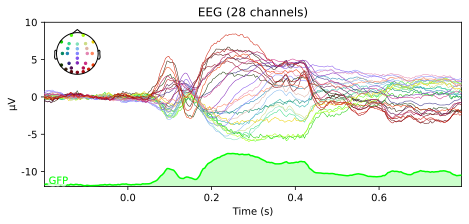

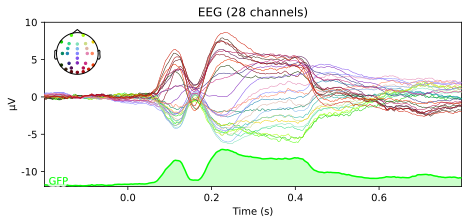

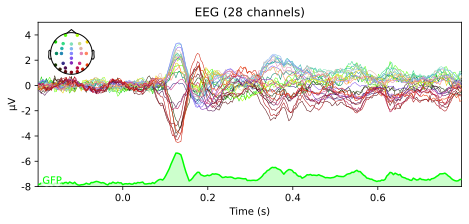

In [7]:
fig = erp1.plot(gfp=True, ylim = dict(eeg=[-12, 10]));

fig = erp2.plot(gfp=True, ylim = dict(eeg=[-12, 10]));

fig = erp_diff.plot(gfp=True, ylim = dict(eeg=[-8, 5]));

No projector specified for this dataset. Please consider the method self.add_proj.


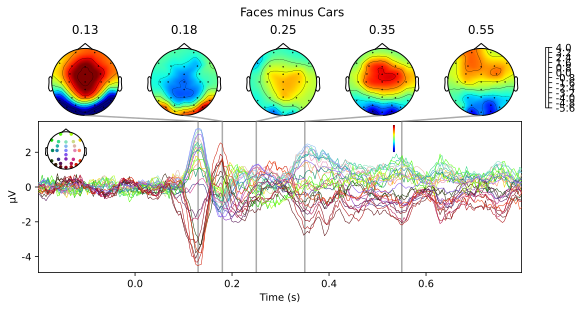

In [12]:
tp_args = { "vlim":(-3, 3), "time_format":'%3.2f', "contours":10, "cmap":"jet" }
erp_diff.plot_joint(title='Faces minus Cars', times=[0.13, 0.18, 0.25, 0.35, 0.55], topomap_args=tp_args); 

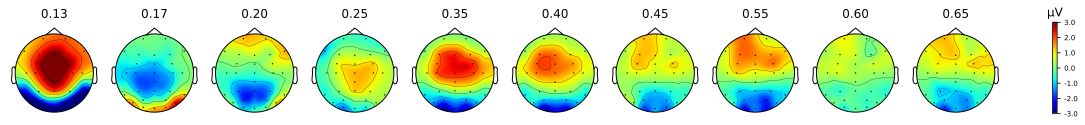

In [13]:
erp_diff.plot_topomap(cmap="jet", vlim=[-3, 3], time_format='%3.2f', 
                      times=[0.13, 0.17, 0.2, 0.25, 0.35, 0.4, 0.45, 0.55, 0.6, 0.65], nrows=1 );

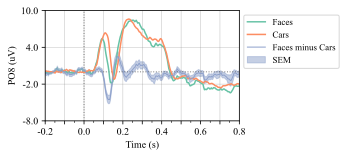

In [10]:
ch_index = epo.ch_names.index('PO8')

erp_data_1 = erp_data_mean[0][ch_index] * 1e6
erp_data_2 = erp_data_mean[1][ch_index] * 1e6

n_sub = erp_data.shape[0] # [40, 2, 28, 256] 
erp_data_diff_sem = np.std((erp_data[:,0,ch_index]-erp_data[:,1,ch_index]) * 1e6, axis=0, ddof=0)/np.sqrt(n_sub)

colors = sns.color_palette('Set2')

plt.figure(figsize=(3.5, 2))

ax = plt.gca()
# ax.axvspan(0, 100, alpha=0.1, color='grey')
plt.grid(color='gray', linewidth=0.5, alpha=0.5, linestyle='-')
plt.axhline(0.0, color='k', linewidth=1.0, linestyle=':', alpha=0.5)
plt.axvline(51.2, color='k', linewidth=1.0, linestyle=':', alpha=0.5)

# filter
mean_line1 = savgol_filter(erp_data_1, 4, 2) # win_size: 4, order: 3
mean_line2 = savgol_filter(erp_data_2, 4, 2) # win_size: 4, order: 3

diff_line = mean_line1 - mean_line2
sem_line1 = diff_line - erp_data_diff_sem
sem_line2 = diff_line + erp_data_diff_sem

plt.plot(mean_line1, label='Faces', color=colors[0])    
plt.plot(mean_line2, label='Cars', color=colors[1])
plt.plot(diff_line, label='Faces minus Cars', linewidth=1.0, color=colors[2])

plt.fill_between(range(256), sem_line1, sem_line2, alpha=0.5, label='SEM', color=colors[2] )    

ax.xaxis.set_minor_locator(MultipleLocator(12.8))
plt.xlim([0,256])
plt.ylim([-8, 10])
    
plt.legend(prop={'family':'Times New Roman', 'size':9}, ncol = 1, bbox_to_anchor=(1.0, 1.0))

font = {'family' : 'Times New Roman', # 'Microsoft YaHei' 'SimHei' 'serif' 
        'color'  : 'k',
        'weight' : 'normal',
        'size'   : 10,
        }

plt.xticks(np.linspace(0, 256, 11, endpoint=True), ['-0.2', '',  '0.0', '', '0.2', '', '0.4', '', '0.6', '', '0.8'], fontdict=font);
# ['-0.2', '-0.1',  '0.0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8']
plt.xlabel("Time (s)", fontdict=font)
plt.yticks(np.linspace(-8, 10, 4, endpoint=True), np.linspace(-8, 10, 4, endpoint=True), fontdict=font);
plt.ylabel("PO8 (uV)", fontdict=font);


# Calculate spatial covariance matrix

In [11]:
# time [-0.2, 0.8] 256Hz 
# epo.time_as_index(0.0)  51
# epo.time_as_index(0.7)  231
# slide_window 0.1s [-12, 12]

half_win = 12

start_t = 51
end_t = 231
len_t = 180

cov_mat = 0
cov_diag = 0
cov_data = 0
crop_erp = 0

flag = 0
for tp in range(type_num):

    data = erp_data_norm[tp]

    cov_mat_epoch = np.empty((len_t, ch_num, ch_num))
    cov_data_epoch = np.empty(( len_t, int(ch_num*((ch_num+1)/2)) ))
    cov_diag_epoch = np.empty(( len_t, ch_num ))

    for ind, t in enumerate(range(start_t, end_t)):
        # calculate covariance matrix
        cov = np.cov(data[:, t-half_win:t+half_win])
        # get the triangle elements of the matrix
        cov_data_epoch[ind] = cov[np.triu_indices(cov.shape[0], k=0)]
        cov_diag_epoch[ind] = np.diagonal(cov)
        # shrunk
        cov = shrunk_covariance(cov, shrinkage=0.01)
        cov_mat_epoch[ind] = cov
                
    if flag == 0:
        flag = 1
        cov_mat = cov_mat_epoch
        cov_diag = cov_diag_epoch
        cov_data = cov_data_epoch
        crop_erp = erp_data_mean[tp, :, start_t:end_t].T
    else:
        cov_data = np.vstack((cov_data, cov_data_epoch))
        cov_diag = np.vstack((cov_diag, cov_diag_epoch))
        cov_mat = np.vstack((cov_mat, cov_mat_epoch))
        crop_erp = np.vstack((crop_erp, erp_data_mean[tp, :, start_t:end_t].T))

print( crop_erp.shape ) # [times, chs]
print( cov_mat.shape )  # [times, chs, chs]
print( cov_diag.shape ) # [times, chs]
print( cov_data.shape ) # [times, diag] # 14 * 29
print( type_num*len_t, int(ch_num*((ch_num+1)/2)) ) # 360 = 2 * 180

(360, 28)
(360, 28, 28)
(360, 28)
(360, 406)
360 406


In [4]:
# with open('./tmp_data/raw_eeg_data.pkl', 'wb') as f:
#     dill.dump([erp_data, erp_data_mean, cov_mat, cov_data, cov_diag, crop_erp], f)

with open('./tmp_data/raw_eeg_data.pkl', 'rb') as f:
    [erp_data, erp_data_mean, cov_mat, cov_data, cov_diag, crop_erp] = dill.load(f)

## Plot covariance matrices

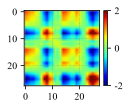

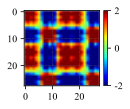

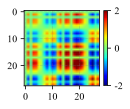

In [13]:
def draw_cov_mat(ind):
    fig, ax = plt.subplots(figsize=(1.5, 1.5))
    ax0 = ax.matshow(cov_mat[ind], interpolation='none', vmin=-2, vmax=2.0, cmap='jet');# cmap='turbo', 
    clb = fig.colorbar(ax0, fraction=0.045);
    ax.xaxis.set_ticks_position("bottom")
    plt.grid(color='gray', linestyle=':', linewidth=0.5);
    clb.set_ticks(ticks=[-2, 0, 2])
    cbar_label = clb.ax.get_xticklabels() + clb.ax.get_yticklabels()
    [lab.set_font('Times New Roman') for lab in cbar_label]  #Times New Roman Arial
    clb.ax.tick_params(labelsize=10)
    ax.set_xticks(np.arange(0,30,10), np.arange(0,30,10), fontdict=font);
    ax.set_yticks(np.arange(0,30,10), np.arange(0,30,10), fontdict=font);
    plt.show();

tps = [20, 50, 80]
for tp in tps:
    draw_cov_mat(tp)

# Calculate spatial pattern distance

## distance in observation space

In [14]:
%%writefile calc_dist_o_fun.py

import scipy
import numpy as np

def calc_dist_o(cov1, cov2):
    evals, _ = scipy.linalg.eigh(cov1,cov2)
    res = evals[-1] #np.max(evals) 
    
    return res

Overwriting calc_dist_o_fun.py


In [15]:
import calc_dist_o_fun
import multiprocessing

num_cores = int(multiprocessing.cpu_count())

print("CPU cores: ", num_cores)

CPU cores:  32


In [16]:
tp = cov_mat.shape[0]

cov_dist_o = np.full((tp, tp), np.nan)

for i in range(tp):
    if i % 200 == 0: # ~3min
        print(i)
 
    pool = multiprocessing.Pool(processes = num_cores)
    res = []
    for j in range(i+1, tp):        
        r = pool.apply_async(calc_dist_o_fun.calc_dist_o, args=( cov_mat[i], cov_mat[j] )) 
        res.append(r)

    pool.close()

    evals_i = np.squeeze( [p.get() for p in res] )
    cov_dist_o[i, i+1:] = evals_i

0
200


In [5]:
# with open('./tmp_data/cov_dist_o.pkl', 'wb') as f:
#     dill.dump(cov_dist_o, f)

with open('./tmp_data/cov_dist_o.pkl', 'rb') as f:
    cov_dist_o = dill.load(f)

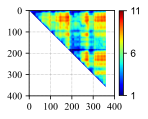

In [18]:
fig, ax = plt.subplots(figsize=(1.7, 1.7))
ax0 = ax.matshow(np.log(cov_dist_o), interpolation='none', vmin=1.0, vmax=11.0, cmap='jet');
clb = fig.colorbar(ax0, fraction=0.045);
ax.xaxis.set_ticks_position("bottom")
plt.grid(color='gray', linestyle=':', linewidth=0.5);
clb.set_ticks(ticks=[1, 6, 11])
cbar_label = clb.ax.get_xticklabels() + clb.ax.get_yticklabels()
[lab.set_font('Arial') for lab in cbar_label]  #Times New Roman  #set_fontstyle
clb.ax.tick_params(labelsize=10)
ax.set_xticks(np.arange(0,401,100), np.arange(0,401,100), fontdict=font);
ax.set_yticks(np.arange(0,401,100), np.arange(0,401,100), fontdict=font);
plt.show();

In [19]:
norm_cov_dist_o = np.log(cov_dist_o)
norm_cov_dist_o /= (np.nanmax(norm_cov_dist_o))

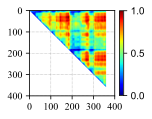

In [20]:
fig, ax = plt.subplots(figsize=(1.7, 1.7))
ax0 = ax.matshow(norm_cov_dist_o, interpolation='none', vmin=0.0, vmax=1.0, cmap='jet', );
clb = fig.colorbar(ax0, fraction=0.045);
ax.xaxis.set_ticks_position("bottom")
plt.grid(color='gray', linestyle=':', linewidth=0.5);
clb.set_ticks(ticks=[0, 0.5, 1])
cbar_label = clb.ax.get_xticklabels() + clb.ax.get_yticklabels()
[lab.set_font('Arial') for lab in cbar_label] 
clb.ax.tick_params(labelsize=10)
ax.set_xticks(np.arange(0,401,100), np.arange(0,401,100), fontdict=font);
ax.set_yticks(np.arange(0,401,100), np.arange(0,401,100), fontdict=font);
plt.show();

## distance in source space

In [21]:
%%writefile calc_dist_s_fun.py

import scipy
import numpy as np

def calc_dist_s(cov1, cov2):

    d2 = (np.log(scipy.linalg.eigvalsh(cov1,cov2))**2).sum(axis=-1)
    riemann_dist = np.sqrt(d2) 
    
    return riemann_dist

Overwriting calc_dist_s_fun.py


In [22]:
import calc_dist_s_fun
import multiprocessing

num_cores = int(multiprocessing.cpu_count())

print("CPU cores: ", num_cores)

CPU cores:  32


In [23]:
tp = cov_mat.shape[0]

cov_dist_s = np.full((tp, tp), np.nan)

for i in range(tp):
    if i % 200 == 0: # ~3min
        print(i)

    pool = multiprocessing.Pool(processes = num_cores)
    res = []
    for j in range(i+1, tp):        
        r = pool.apply_async(calc_dist_s_fun.calc_dist_s, args=( cov_mat[i], cov_mat[j] ))
        res.append(r)

    pool.close()

    riemann_dist_i = np.squeeze( [p.get() for p in res] )
    cov_dist_s[i, i+1:] = riemann_dist_i

0
200


In [6]:
# with open('./tmp_data/cov_dist_s.pkl', 'wb') as f:
#     dill.dump(cov_dist_s, f)

with open('./tmp_data/cov_dist_s.pkl', 'rb') as f:
    cov_dist_s = dill.load(f)

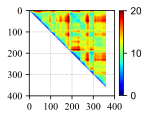

In [25]:
fig, ax = plt.subplots(figsize=(1.7, 1.7))
ax0 = ax.matshow(cov_dist_s, interpolation='none', vmin=0.0, vmax=20.0, cmap='jet', );# 
clb = fig.colorbar(ax0, fraction=0.045);
ax.xaxis.set_ticks_position("bottom")
plt.grid(color='gray', linestyle=':', linewidth=0.5);
clb.set_ticks(ticks=[0, 10, 20])
cbar_label = clb.ax.get_xticklabels() + clb.ax.get_yticklabels()
[lab.set_font('Arial') for lab in cbar_label]  #Times New Roman  #set_fontstyle
clb.ax.tick_params(labelsize=10)

ax.set_xticks(np.arange(0,401,100), np.arange(0,401,100), fontdict=font);
ax.set_yticks(np.arange(0,401,100), np.arange(0,401,100), fontdict=font);
plt.show();

In [26]:
norm_cov_dist_s = copy.deepcopy(cov_dist_s)
norm_cov_dist_s /= (np.nanmax(norm_cov_dist_s))

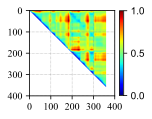

In [27]:
fig, ax = plt.subplots(figsize=(1.7, 1.7))
ax0 = ax.matshow(norm_cov_dist_s, interpolation='none', vmin=0.0, vmax=1.0, cmap='jet', );
clb = fig.colorbar(ax0, fraction=0.045);
ax.xaxis.set_ticks_position("bottom")
plt.grid(color='gray', linestyle=':', linewidth=0.5);
clb.set_ticks(ticks=[0, 0.5, 1])
cbar_label = clb.ax.get_xticklabels() + clb.ax.get_yticklabels()
[lab.set_font('Arial') for lab in cbar_label]
clb.ax.tick_params(labelsize=10)

ax.set_xticks(np.arange(0,401,100), np.arange(0,401,100), fontdict=font);
ax.set_yticks(np.arange(0,401,100), np.arange(0,401,100), fontdict=font);
plt.show();

# Multi-dimensional Scaling

In [28]:
norm_dist_o_symm = np.ones_like(norm_cov_dist_o)
for i in range(norm_cov_dist_o.shape[0]):
    for j in range(i+1, norm_cov_dist_o.shape[0]):
        norm_dist_o_symm[i,j] = norm_cov_dist_o[i,j]
        norm_dist_o_symm[j,i] = norm_cov_dist_o[i,j]

mds = MDS(n_components=28, dissimilarity='precomputed', metric=True, 
          n_jobs=32, random_state=3, normalized_stress='auto') 
features_dist_o = mds.fit_transform(norm_dist_o_symm)

features_dist_o.shape

(360, 28)

In [29]:
norm_dist_s_symm = np.ones_like(norm_cov_dist_s)
for i in range(norm_cov_dist_s.shape[0]):
    for j in range(i+1, norm_cov_dist_s.shape[0]):
        norm_dist_s_symm[i,j] = norm_cov_dist_s[i,j]
        norm_dist_s_symm[j,i] = norm_cov_dist_s[i,j]

mds = MDS(n_components=28, dissimilarity='precomputed', metric=True, 
          n_jobs=32, random_state=3, normalized_stress='auto')
features_dist_s = mds.fit_transform(norm_dist_s_symm)

features_dist_s.shape 

(360, 28)

In [7]:
# with open('./tmp_data/distance_mds_data.pkl', 'wb') as f:
#     dill.dump([features_dist_o, features_dist_s], f)

with open('./tmp_data/distance_mds_data.pkl', 'rb') as f:
    [features_dist_o, features_dist_s] = dill.load(f)

# Data normlization

In [31]:
norm_cov_diag = np.log(10*cov_diag)

norm_dist_o = 20*features_dist_o

norm_dist_s = 20*features_dist_s

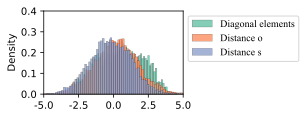

In [32]:
import warnings
warnings.filterwarnings('ignore')

font = {'family':['Times New Roman', 'Arial', ], 'weight':'normal', 'size':10 }
colors = sns.color_palette('Set2')

plt.figure(figsize=(2.5, 1.5))

sns.histplot(norm_cov_diag.flatten()-0.4, bins=80, stat='density', legend=False, color=colors[0], alpha=0.8, )
sns.histplot(norm_dist_o.flatten()+0.2, bins=80, stat='density', legend=False, color=colors[1], alpha=0.8, )
sns.histplot(norm_dist_s.flatten()-0.2, bins=80, stat='density', legend=False, color=colors[2], alpha=0.8, )

plt.xlim([-5, 5])
plt.ylim([0, 0.4])

plt.legend(labels=['Diagonal elements', 'Distance o', 'Distance s'], prop=font, bbox_to_anchor=(1.0, 1.0));

In [33]:
input_data_raw = np.hstack((norm_cov_diag, norm_dist_o, norm_dist_s))
print(input_data_raw.shape) #[360, 84]

input_data = torch.from_numpy(input_data_raw).type(torch.FloatTensor) #[samples, features]

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

(360, 84)
cuda:0


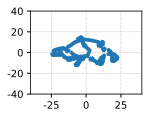

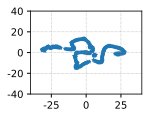

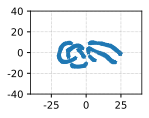

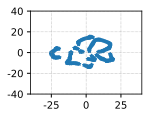

In [34]:
tsne = TSNE(n_components=2, init='pca', random_state=0, n_jobs=-1, perplexity=30)

for data in [norm_cov_diag, norm_dist_o, norm_dist_s, input_data_raw]:
    tsne_2d = tsne.fit_transform(data)

    fig, axi1=plt.subplots(1, figsize=(2, 1.5))    
    axi1.scatter(tsne_2d[:, 0], tsne_2d[:, 1],
                marker='*', s=10, color=sns.color_palette('Paired')[1],
                )

    ax = plt.gca()
    plt.grid(True, linewidth=0.5, color='gray', linestyle=':')
    plt.xlim([-40, 40])
    plt.ylim([-40, 40])
    # plt.yticks([-100,-50,0,50,100],[-100,-50,0,50,100])
    # plt.xticks([-100,-50,0,50,100],[-100,-50,0,50,100])

    ax.tick_params(which='both', bottom=True, top=False, left=True, right=False,
                labelbottom=True, labelleft=True, direction='out',width=1)
    plt.show()

In [8]:
# with open('./tmp_data/network_input_data.pkl', 'wb') as f:
#     dill.dump([norm_cov_diag, norm_dist_o, norm_dist_s, input_data_raw], f)

with open('./tmp_data/network_input_data.pkl', 'rb') as f:
    [norm_cov_diag, norm_dist_o, norm_dist_s, input_data_raw] = dill.load(f)

# Train AutoEncoder Network

In [36]:
import importlib

importlib.reload(UDEC_Network)

<module 'utils.UDEC_Network' from 'e:\\论文写作\\论文2\\N170\\utils\\UDEC_Network.py'>

In [37]:
EPOCHS_PRE = 1001
LR_PRE = 1e-3 # dynamic adjust learning rate
BATCH_SIZE = 32

autoencoder = UDEC_Network.AutoEncoder().to(device)
checkpoint = { "epoch": 0, "best": float("inf") }
file_path_prefix = './network_data/'
ae_save_path = file_path_prefix + 'autoencoder.pth'

UDEC_Network.pretrain(data=input_data, model=autoencoder, savepath=ae_save_path, 
                      checkpoint=checkpoint, file_path_prefix=file_path_prefix, 
                      num_epochs=EPOCHS_PRE, batch_size=BATCH_SIZE, lr=LR_PRE)

epoch [1/1001], MSE_loss:2.20673
epoch [2/1001], MSE_loss:1.69884
epoch [3/1001], MSE_loss:1.60556
epoch [4/1001], MSE_loss:1.15251
epoch [5/1001], MSE_loss:1.40224
epoch [6/1001], MSE_loss:1.32023
epoch [7/1001], MSE_loss:1.00663
epoch [8/1001], MSE_loss:1.12145
epoch [9/1001], MSE_loss:1.13765
epoch [10/1001], MSE_loss:0.95416
epoch [11/1001], MSE_loss:0.88185
epoch [12/1001], MSE_loss:0.85678
epoch [13/1001], MSE_loss:0.91871
epoch [14/1001], MSE_loss:1.07839
epoch [15/1001], MSE_loss:0.93291
epoch [16/1001], MSE_loss:0.60339
epoch [17/1001], MSE_loss:0.71961
epoch [18/1001], MSE_loss:0.77097
epoch [19/1001], MSE_loss:0.76433
epoch [20/1001], MSE_loss:0.57989
epoch [21/1001], MSE_loss:0.57952
epoch [22/1001], MSE_loss:0.60240
epoch [23/1001], MSE_loss:0.48501
epoch [24/1001], MSE_loss:0.57349
epoch [25/1001], MSE_loss:0.58310
epoch [26/1001], MSE_loss:0.56255
epoch [27/1001], MSE_loss:0.33552
epoch [28/1001], MSE_loss:0.35851
epoch [29/1001], MSE_loss:0.61156
epoch [30/1001], MSE_lo

## latent features visualization

In [38]:
input_data_device = input_data.to(device)

latent_features = autoencoder.encode(input_data_device).detach().cpu().numpy()

print(latent_features.shape)

(360, 16)


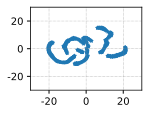

In [39]:
tsne = TSNE(n_components=2, init='pca', random_state=0, n_jobs=-1, perplexity=30)

tsne_2d = tsne.fit_transform(latent_features)

fig, axi1=plt.subplots(1, figsize=(2, 1.5))
axi1.scatter(tsne_2d[:, 0], tsne_2d[:, 1],
            marker='*', s=10, color=sns.color_palette('Paired')[1],
            )

ax = plt.gca()
plt.grid(True, linewidth=0.5, color='gray', linestyle=':')
plt.xlim([-30, 30])
plt.ylim([-30, 30])
# plt.yticks([-100,-50,0,50,100],[-100,-50,0,50,100])
# plt.xticks([-100,-50,0,50,100],[-100,-50,0,50,100])

ax.tick_params(which='both', bottom=True, top=False, left=True, right=False,
            labelbottom=True, labelleft=True, direction='out',width=1)
plt.show()

# Train clustering network

In [40]:
tmp = copy.deepcopy(input_data_raw)

np.random.shuffle(tmp)
np.random.shuffle(tmp)

data_shuffle = torch.from_numpy(tmp).type(torch.FloatTensor)

In [41]:
importlib.reload(UDEC_Network)

<module 'utils.UDEC_Network' from 'e:\\论文写作\\论文2\\N170\\utils\\UDEC_Network.py'>

In [42]:
EPOCHS = 10001
BATCH_SIZE = 512
lr = 0.6
file_path_prefix = './network_data/'

for ind, n_c in enumerate([8, 10, 12]):

    autoencoder = UDEC_Network.AutoEncoder().to(device)
    ae_save_path = file_path_prefix + 'autoencoder.pth'
    checkpoint = torch.load(ae_save_path)
    autoencoder.load_state_dict(checkpoint['state_dict'])

    dec = UDEC_Network.DEC(n_clusters=n_c, autoencoder=autoencoder, hidden=16, cluster_centers=None, alpha=2.0).to(device)

    dec_save_path = file_path_prefix + 'dec-' + str(n_c) + '-clusters' + '.pth'
    checkpoint = { "epoch": 0, "best": float("inf") }
    UDEC_Network.train(data=data_shuffle, model=dec, num_epochs=EPOCHS, 
                            n_cluster=n_c, draw_pic=True, lr=lr, file_path_prefix=file_path_prefix, 
                            savepath=dec_save_path, checkpoint=checkpoint, batch_size=BATCH_SIZE)

Training
plotting
Epochs: [0/10001] Loss:0.22805804014205933
Epochs: [1000/10001] Loss:0.005099236965179443
Epochs: [2000/10001] Loss:0.0034260167740285397
Epochs: [3000/10001] Loss:0.002703610109165311
Epochs: [4000/10001] Loss:0.0022824450861662626
plotting
Epochs: [5000/10001] Loss:0.0020003465469926596
Epochs: [6000/10001] Loss:0.001795316464267671
Epochs: [7000/10001] Loss:0.001638207584619522
Epochs: [8000/10001] Loss:0.001513019553385675
Epochs: [9000/10001] Loss:0.0014104674337431788
plotting
Epochs: [10000/10001] Loss:0.0013245934387668967
Training
plotting
Epochs: [0/10001] Loss:0.2488413155078888
Epochs: [1000/10001] Loss:0.00670035183429718
Epochs: [2000/10001] Loss:0.0044983853586018085
Epochs: [3000/10001] Loss:0.003548107575625181
Epochs: [4000/10001] Loss:0.0029942328110337257
plotting
Epochs: [5000/10001] Loss:0.002623306354507804
Epochs: [6000/10001] Loss:0.0023538924288004637
Epochs: [7000/10001] Loss:0.0021474051754921675
Epochs: [8000/10001] Loss:0.0019829969387501

# K-Means clustering of latent features 

In [43]:
data = torch.from_numpy(input_data_raw).type(torch.FloatTensor)

num_clusters = [8,10,12]

latent_vec = np.empty( (len(num_clusters), data.size()[0], 16) )  # [n_c, frames, n_hidden]
pred_label = np.empty( (len(num_clusters), data.size()[0]) )
pred_center = []

file_path_prefix = './network_data/'
for ind, n_c in enumerate(num_clusters): 

    # load model
    autoencoder = UDEC_Network.AutoEncoder()

    dec = UDEC_Network.DEC(n_clusters=n_c, autoencoder=autoencoder, hidden=16, cluster_centers=None, alpha=2.0)
    dec_save_path = file_path_prefix + 'dec-' + str(n_c) + '-clusters' + '.pth'
    checkpoint = torch.load(dec_save_path)
    dec.load_state_dict(checkpoint['state_dict']);

    # calculate latent vectors
    latent_vec[ind] = autoencoder.encode(input_data).detach().cpu().numpy()

    # get cluster centers
    cluster = KMeans(n_clusters=num_clusters[ind], random_state=0, n_init=10*num_clusters[ind]).fit(latent_vec[ind])

    # get cluster labels
    centroid = cluster.cluster_centers_
    pred_center.append(centroid)
    pred_label[ind] = cluster.labels_ 

pred_label += 1

In [44]:
# with open('./tmp_data/eeg_data_udec_clustering_results.pkl', 'wb') as f:
#     dill.dump([pred_center, pred_label, centroid, latent_vec], f)

In [9]:
with open('./tmp_data/eeg_data_udec_clustering_results.pkl', 'rb') as f:
    [pred_center, pred_label, centroid, latent_vec] = dill.load(f)

# T-SNE visualization

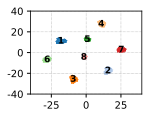

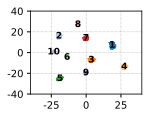

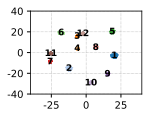

In [46]:
tsne = TSNE(n_components=2, init='pca', random_state=0, n_jobs=-1, perplexity=30)

colors = sns.color_palette('pastel')

for ind, n_c in enumerate(num_clusters): 

    lf_with_center = np.vstack((latent_vec[ind], pred_center[ind]))

    kmeans_2d_with_center = tsne.fit_transform(lf_with_center)    
    kmeans_2d = kmeans_2d_with_center[:-n_c, :]
    kmeans_2d_center = kmeans_2d_with_center[-n_c:, :]

    fig, axi1=plt.subplots(1, figsize=(2, 1.5))    
    for i in range(n_c):
        axi1.scatter( kmeans_2d[pred_label[ind] == i+1, 0], 
                      kmeans_2d[pred_label[ind] == i+1, 1],
                      marker='*',
                      s=10,
                      color=plt.cm.tab20(i%20),
                    )
        axi1.text(kmeans_2d_center[i,0], kmeans_2d_center[i,1], 
                  i+1, fontsize=9, fontweight='semibold', 
                  verticalalignment='center', horizontalalignment='center', 
                  color='black', 
                )

    ax = plt.gca()
    plt.grid(True, linewidth=0.5, color='gray', linestyle=':')
    plt.xlim([-40, 40])
    plt.ylim([-40, 40])
    # plt.yticks([-100,-50,0,50,100],[-100,-50,0,50,100])
    # plt.xticks([-100,-50,0,50,100],[-100,-50,0,50,100])

    ax.tick_params(which='both', bottom=True, top=False, left=True, right=False,
                labelbottom=True, labelleft=True, direction='out',width=1)
    plt.show()

# Find index of cluster centers

In [32]:
euc_center_index = []
rie_center_index = []

num_clusters = [8,10,12]

riemann_dist_symmetry = np.zeros_like(cov_dist_s)
for i in range(cov_dist_s.shape[0]):
    for j in range(i+1, cov_dist_s.shape[0]):
        riemann_dist_symmetry[i,j] = cov_dist_s[i,j]
        riemann_dist_symmetry[j,i] = cov_dist_s[i,j]

# Euclidean distance of lantent vectors
for i, n_c in enumerate(num_clusters):
    tmp_c = []
    for n in range(n_c):
        distance = np.sum(np.square(latent_vec[i][pred_label[i]==(n+1)] - pred_center[i][n]), axis=1)
        index = distance.argmin()
        tmp_c.append( np.argwhere(pred_label[i]==(n+1))[index][0] )
    euc_center_index.append(tmp_c)

# Riemann distance
for i, n_c in enumerate(num_clusters):
    tmp_c = []
    for n in range(n_c):

        tmp = riemann_dist_symmetry[pred_label[i]==(n+1), :]
        tmp2 = tmp[:, pred_label[i]==(n+1)]
        distance = np.sum(tmp2, axis=0)

        index = distance.argmin()
        tmp_c.append( np.argwhere(pred_label[i]==(n+1))[index][0] )
    rie_center_index.append(tmp_c)

In [33]:
print(euc_center_index[1])

print(rie_center_index[1])

[203, 269, 232, 133, 309, 298, 242, 89, 146, 182]
[207, 352, 50, 120, 323, 287, 256, 89, 156, 188]


In [34]:
clu_index = 0 # 8 clusters

cog_condition = [] # 2 conditions
time_index = [] # 0-180 time window

for ci in rie_center_index[clu_index]:
    cog_condition.append( 1+int(ci/180) )
    time_index.append( ci%180 )

In [35]:
print(cog_condition)
print(time_index)

[2, 2, 2, 1, 1, 2, 2, 2]
[26, 143, 88, 120, 53, 75, 56, 107]


# t-test of clustering results

[]


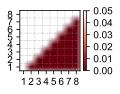

[]


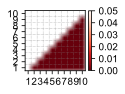

[]


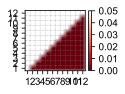

In [18]:
import importlib
importlib.reload(ttest_for_clusters)

for n_c in range(len(num_clusters)):
    p_res = ttest_for_clusters.distance_ttest(pred_label[n_c], cov_dist_s, samp_num=500)
    ttest_for_clusters.draw_test_mat(p_res, corr_p=True)

# Plot microstate series

In [36]:
cluster_number_index = 0 # 8 clusters

each_condition_label = np.full((2, 180), np.nan)

type_num = 2
for tp in range(type_num):
    st = tp*180
    ed = st+180
    
    each_condition_label[tp] = pred_label[cluster_number_index, st:ed]

each_condition_label[1][9:12] = 1

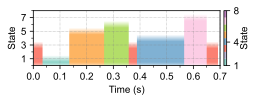

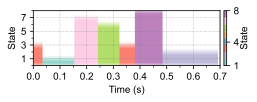

In [39]:
for sym in range(type_num):
    draw_states.draw_state_blocks_for_eeg(each_condition_label[sym], figsize=(3.5, 1.0), n_clusters=8,
                                          #  n_clusters=int(np.max(each_condition_label[sym])),
                                          colorbar_fraction=0.015, tmin=0.0, tmax=0.7, 
                                          colorbar_ticks=[1,4,8]);

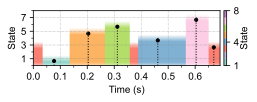

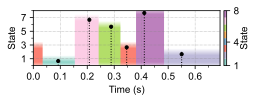

In [93]:
importlib.reload(draw_states)

for sym in range(type_num):
    draw_states.draw_state_blocks_for_eeg(each_condition_label[sym], figsize=(3.5, 1.0), n_clusters=8,
                                          #  n_clusters=int(np.max(each_condition_label[sym])),
                                          colorbar_fraction=0.015, tmin=0.0, tmax=0.7, 
                                          colorbar_ticks=[1,4,8], rie_dist=cov_dist_s, current_cluster=sym);

# Draw center EEG topomap

In [40]:
# erp_data_mean [2, 28, 256]
half_win = 12
start_t = 51
end_t = 231
len_t = 180

eeg_state_centers = np.zeros((8, 28))

for i, cog_ind in enumerate(cog_condition):
    eeg_state_centers[i] = np.mean(erp_data_mean[cog_ind-1, :, ((time_index[i]+start_t)-half_win):((time_index[i]+start_t)+half_win)], axis=1)

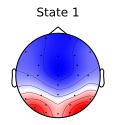

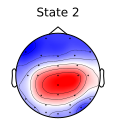

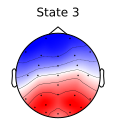

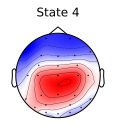

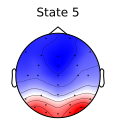

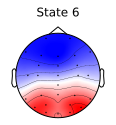

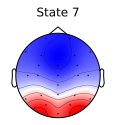

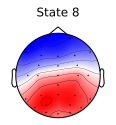

In [51]:
draw_states.draw_grand_average_topo(eeg_state_centers, epo, cmap='bwr', draw_separate=True, colorbar=False);

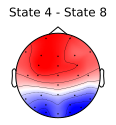

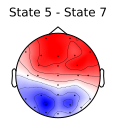

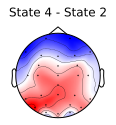

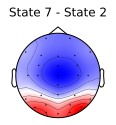

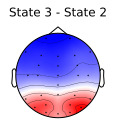

In [47]:
draw_states.draw_topo_diff(eeg_state_centers[3,:]-eeg_state_centers[7,:], epo, title='State 4 - State 8', cmap='bwr');

draw_states.draw_topo_diff(eeg_state_centers[4,:]-eeg_state_centers[6,:], epo, title='State 5 - State 7', cmap='bwr');

draw_states.draw_topo_diff(eeg_state_centers[3,:]-eeg_state_centers[1,:], epo, title='State 4 - State 2', cmap='bwr');

draw_states.draw_topo_diff(eeg_state_centers[6,:]-eeg_state_centers[1,:], epo, title='State 7 - State 2', cmap='bwr');

draw_states.draw_topo_diff(eeg_state_centers[2,:]-eeg_state_centers[1,:], epo, title='State 3 - State 2', cmap='bwr');